# **mini challenge**

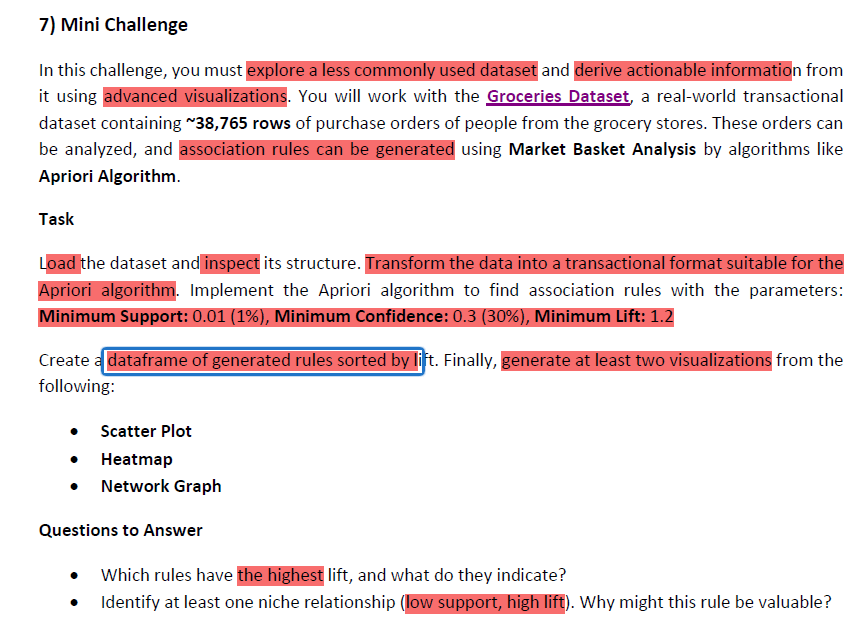

# **1. Importing All Necessary Libraries**

In [ ]:
# Install it if not installed
!pip install apyori

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
import plotly.express as px
from apyori import apriori

# Plot styles to set aesthetic preferences for your visualizations.
sns.set()
plt.style.use('ggplot')

# **2. Dataset Overview**

## **2.1 Installing Kaggle**

In [ ]:
!pip install kaggle

## **2.2 Downloading The Dataset Files**

In [ ]:
!kaggle datasets download -d heeraldedhia/groceries-dataset

Dataset URL: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset
License(s): GPL-2.0
groceries-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip groceries-dataset.zip

Archive:  groceries-dataset.zip
replace Groceries_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Groceries_dataset.csv   


In [ ]:
df = pd.read_csv('Groceries_dataset.csv')

# **3 Inspecting the dataset**

In [ ]:
df.shape

(38765, 3)

In [ ]:
df.columns

Index(['Member_number', 'Date', 'itemDescription'], dtype='object')

## Checking for Null values

In [ ]:
df.isnull().any()

,0
Member_number,False
Date,False
itemDescription,False


## Total Products

In [ ]:
all_products = df['itemDescription'].unique()
print("Total products: {}".format(len(all_products)))

Total products: 167


## Displaying products

In [ ]:
df['itemDescription'].value_counts()

,count
itemDescription,
whole milk,2502
other vegetables,1898
rolls/buns,1716
soda,1514
yogurt,1334
...,...
frozen chicken,5
bags,4
baby cosmetics,3


## Top Customer ID

In [ ]:
df['Member_number'].value_counts()

,count
Member_number,
3180,36
2051,33
3050,33
3737,33
2271,31
...,...
4366,2
4072,2
4496,2


## Top 10 frequently sold products in this dataset

In [ ]:
def ditribution_plot(x,y,name=None,xaxis=None,yaxis=None):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(
        title_text=name,
        xaxis_title=xaxis,
        yaxis_title=yaxis
    )
    fig.show()

In [ ]:
x = df['itemDescription'].value_counts()
x = x.sort_values(ascending = False)
x = x[:10]

ditribution_plot(x=x.index, y=x.values, yaxis="Count", xaxis="Products")

# **4. Transforming The Data into Transactional Format**

In [ ]:
# Prepare transactions list
transactions = df.groupby('Member_number')['itemDescription'].apply(list).tolist()

# Display a few transaction
transactions[:5]



[['soda',
  'canned beer',
  'sausage',
  'sausage',
  'whole milk',
  'whole milk',
  'pickled vegetables',
  'misc. beverages',
  'semi-finished bread',
  'hygiene articles',
  'yogurt',
  'pastry',
  'salty snack'],
 ['frankfurter',
  'frankfurter',
  'beef',
  'sausage',
  'whole milk',
  'soda',
  'curd',
  'white bread',
  'whole milk',
  'soda',
  'whipped/sour cream',
  'rolls/buns'],
 ['tropical fruit',
  'butter milk',
  'butter',
  'frozen vegetables',
  'sugar',
  'specialty chocolate',
  'whole milk',
  'other vegetables'],
 ['sausage',
  'root vegetables',
  'rolls/buns',
  'detergent',
  'frozen meals',
  'rolls/buns',
  'dental care',
  'rolls/buns'],
 ['other vegetables',
  'pip fruit',
  'root vegetables',
  'canned beer',
  'rolls/buns',
  'whole milk',
  'other vegetables',
  'hygiene articles',
  'whole milk',
  'whole milk',
  'frozen fish',
  'red/blush wine',
  'chocolate',
  'shopping bags',
  'dish cleaner',
  'packaged fruit/vegetables',
  'tropical fruit',
 

# **5. Implementation Of Apriori**

In [ ]:
# Define parameters
min_support = 0.01  # 1%
min_confidence = 0.3  # 30%
min_lift = 1.2

# Apply the Apriori algorithm
rules = apriori(transactions, min_support=min_support, min_confidence=min_confidence, min_lift=min_lift)
results = list(rules)

# Display the number of rules generated
print(f"Number of rules generated: {len(results)}")


Number of rules generated: 1449


# **6. extracting information into a dataframe**

In [ ]:
# Extract relevant information
def parse_rules(results):
    rules_data = []
    for result in results:
        items = [item for item in result.items]
        support = result.support
        for ordered_stat in result.ordered_statistics:
            confidence = ordered_stat.confidence
            lift = ordered_stat.lift
            base_items = [item for item in ordered_stat.items_base]
            add_items = [item for item in ordered_stat.items_add]
            rules_data.append({
                'Base Items': ', '.join(base_items),
                'Add Items': ', '.join(add_items),
                'Support': support,
                'Confidence': confidence,
                'Lift': lift
            })
    return pd.DataFrame(rules_data)

rules_df = parse_rules(results)

# Sort rules by lift
rules_df.sort_values(by='Lift', ascending=False, inplace=True)
rules_df.head()


,Base Items,Add Items,Support,Confidence,Lift
2396,"other vegetables, sausage, rolls/buns","whole milk, yogurt",0.013597,0.325153,2.159196
1966,"frozen meals, whole milk","other vegetables, rolls/buns",0.010005,0.307087,2.092699
2390,"bottled water, rolls/buns, yogurt","other vegetables, whole milk",0.010518,0.398058,2.079934
2407,"rolls/buns, yogurt, shopping bags","other vegetables, whole milk",0.010005,0.397959,2.079417
1908,"curd, sausage","whole milk, yogurt",0.010005,0.312000,2.071850


# **7. Visualizations**

## **Scatter Plot**

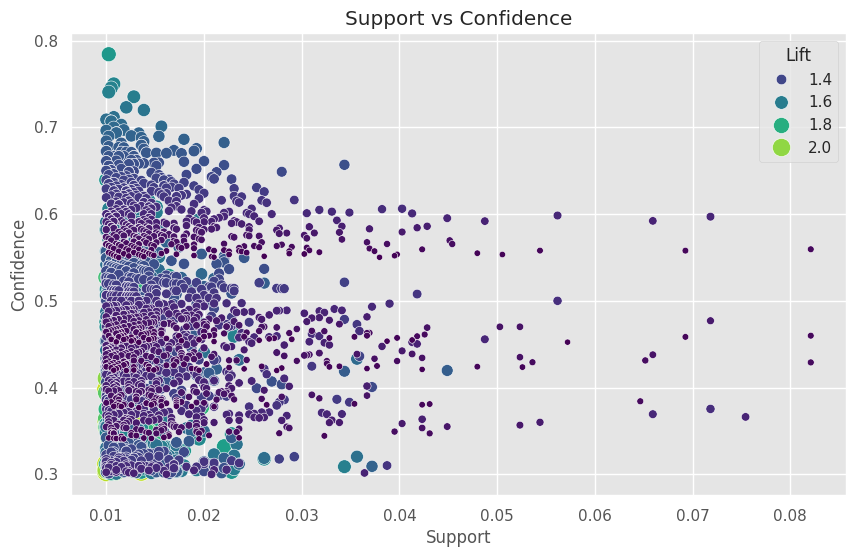

In [ ]:
# Scatter plot for Support vs Confidence
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules_df, x='Support', y='Confidence', size='Lift', hue='Lift', sizes=(20, 200), palette='viridis')
plt.title('Support vs Confidence')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(title='Lift', loc='best')
plt.show()


## **Heatmap**

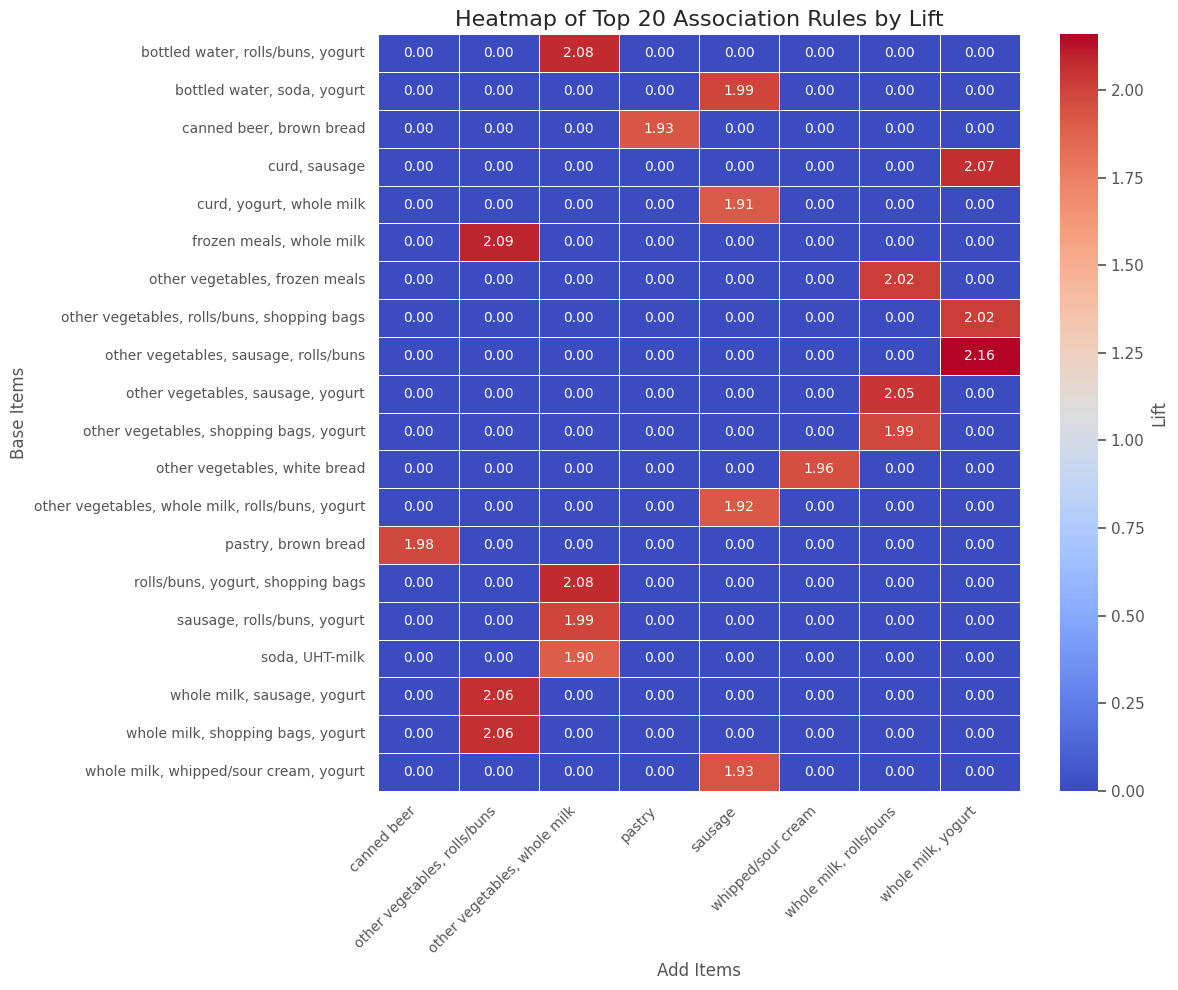

In [ ]:
# Filter to include only the top 20 rules by lift
top_rules = rules_df.sort_values('Lift', ascending=False).head(20)

# Create a pivot table
pivot = top_rules.pivot_table(index='Base Items', columns='Add Items', values='Lift', fill_value=0)

# Plot the heatmap with adjustments
plt.figure(figsize=(12, 10))  # Increase figure size
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Lift'}, linewidths=0.5)
plt.title('Heatmap of Top 20 Association Rules by Lift', fontsize=16)
plt.xlabel('Add Items', fontsize=12)
plt.ylabel('Base Items', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## **Network Graph**

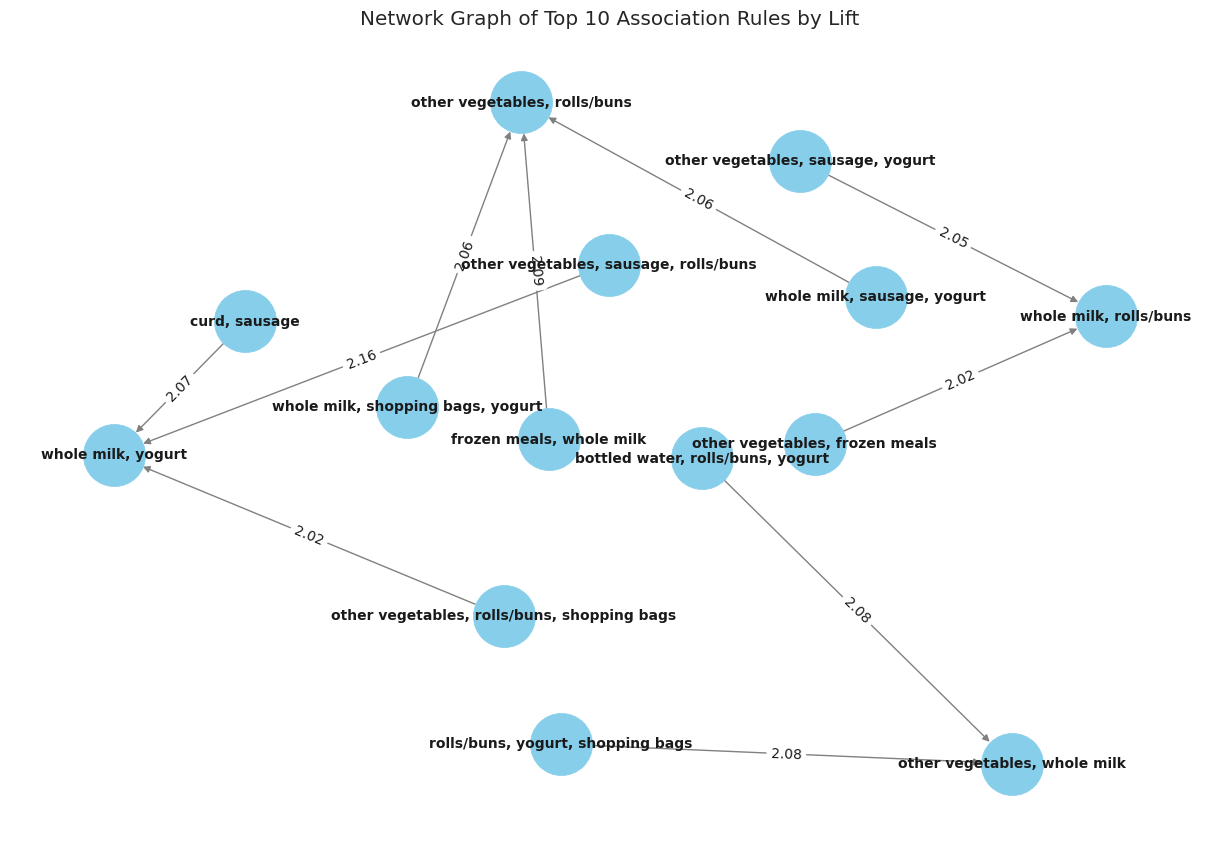

In [ ]:
# Filter the top 10 rules by lift
top_rules_graph = rules_df.sort_values(by='Lift', ascending=False).head(10)

# Create a directed graph
G = nx.DiGraph()

# Add edges for the top 10 rules
for _, row in top_rules_graph.iterrows():
    G.add_edge(row['Base Items'], row['Add Items'], weight=row['Lift'])

# Plot the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)  # Adjust spring layout for better spacing
nx.draw(
    G, pos, with_labels=True, node_size=2000, node_color='skyblue',
    edge_color='gray', font_size=10, font_weight='bold'
)

# Add edge labels showing lift values
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()}
)

plt.title('Network Graph of Top 10 Association Rules by Lift')
plt.tight_layout()
plt.show()


# **Question no. 1**
## **Which rules have the highest lift and what do they indicate?**

In [ ]:
# Top 5 rules by lift
top_lift_rules = rules_df.sort_values(by='Lift', ascending=False).head(5)
print("Top 5 Rules with the Highest Lift:")
top_lift_rules



Top 5 Rules with the Highest Lift:


,Base Items,Add Items,Support,Confidence,Lift
2396,"other vegetables, sausage, rolls/buns","whole milk, yogurt",0.013597,0.325153,2.159196
1966,"frozen meals, whole milk","other vegetables, rolls/buns",0.010005,0.307087,2.092699
2390,"bottled water, rolls/buns, yogurt","other vegetables, whole milk",0.010518,0.398058,2.079934
2407,"rolls/buns, yogurt, shopping bags","other vegetables, whole milk",0.010005,0.397959,2.079417
1908,"curd, sausage","whole milk, yogurt",0.010005,0.312000,2.071850


**These rules indicate the strongest associations between products based on the lift metric.**

# **Question no. 2**
## **Identify at least one niche relationship. Why might this rule be valueable?**

In [ ]:
# Filter for niche relationships: low support (<0.02) and high lift (>2.0)
niche_rules = rules_df[(rules_df['Support'] < 0.02) & (rules_df['Lift'] > 2.0)]
print("Niche Relationships (Low Support, High Lift):")
niche_rules


Niche Relationships (Low Support, High Lift):


,Base Items,Add Items,Support,Confidence,Lift
2396,"other vegetables, sausage, rolls/buns","whole milk, yogurt",0.013597,0.325153,2.159196
1966,"frozen meals, whole milk","other vegetables, rolls/buns",0.010005,0.307087,2.092699
2390,"bottled water, rolls/buns, yogurt","other vegetables, whole milk",0.010518,0.398058,2.079934
2407,"rolls/buns, yogurt, shopping bags","other vegetables, whole milk",0.010005,0.397959,2.079417
1908,"curd, sausage","whole milk, yogurt",0.010005,0.312000,2.071850
2399,"whole milk, sausage, yogurt","other vegetables, rolls/buns",0.013597,0.302857,2.063876
2408,"whole milk, shopping bags, yogurt","other vegetables, rolls/buns",0.010005,0.302326,2.060254
2397,"other vegetables, sausage, yogurt","whole milk, rolls/buns",0.013597,0.365517,2.047107
2405,"other vegetables, rolls/buns, shopping bags","whole milk, yogurt",0.010005,0.304688,2.023291
1964,"other vegetables, frozen meals","whole milk, rolls/buns",0.010005,0.361111,2.022430


**These rules represent items that are not purchased often (low support) but have a strong association when they do co-occur (high lift). These insights can help identify rare but valuable product combinations.**